In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/stats207

/content/drive/My Drive/Colab Notebooks/stats207


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

cite: 
- https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md

# Data Pre-Processing

In [4]:
aqi_weekly = pd.read_csv('aqi_weekly_cleaned.csv')
aqi_weekly.head()

,week,aqi,co,ozone,pm25,no2
0,2012-01-01,75.000000,16.428571,18.857143,75.000000,36.571429
1,2012-01-08,81.714286,17.714286,20.428571,81.714286,44.571429
2,2012-01-15,48.714286,11.428571,28.714286,48.142857,31.857143
3,2012-01-22,40.857143,7.714286,23.714286,39.428571,26.428571
4,2012-01-29,55.285714,8.857143,23.857143,55.285714,33.142857


In [5]:
# Split Train and Test 
train = aqi_weekly.iloc[0:418, 1:].values
test = aqi_weekly.iloc[418:, 1:].values

print(train.shape)
print(test.shape)

(418, 5)
(104, 5)


In [6]:
# Normalize Input 
# scaler = MinMaxScaler() 
scaler = StandardScaler() 

train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [7]:
# Create lagged variables for n timesteps
timesteps = 10
n_cols = 5 

In [8]:
def create_sequences(data, timesteps, n_cols):
  data_timesteps = np.array([[j for j in data[i:i+timesteps+1]] for i in range(0,len(data)-timesteps)])[:,:,]
  n_obs = data_timesteps.shape[0]
  data_timesteps = data_timesteps.reshape(n_obs, (timesteps+1)*n_cols)
  x, y = data_timesteps[:,:-n_cols], data_timesteps[:,[-n_cols]]

  return x, y 

In [9]:
x_train, y_train = create_sequences(train, timesteps, n_cols)
x_test, y_test = create_sequences(test, timesteps, n_cols)

In [10]:
train[0:11]

array([[ 1.94961646,  2.45552678, -1.60596094,  2.22861216,  1.50340785],
       [ 2.43446627,  2.84184711, -1.47059755,  2.67280617,  2.48223495],
       [ 0.05148105,  0.95316994, -0.7568633 ,  0.45183615,  0.92659902],
       [-0.51589638, -0.16286657, -1.187565  , -0.12467096,  0.26239491],
       [ 0.5260149 ,  0.18052928, -1.17525924,  0.92438296,  1.08391052],
       [ 0.26811607,  0.26637824, -0.71994601,  0.60305113,  1.04895241],
       [-0.75316331, -0.46333794, -0.7568633 , -0.41764999,  0.12256247],
       [-0.34052518, -0.20579105, -0.69533448,  0.10215151,  0.41970641],
       [-0.60873996, -0.42041346, -0.28924431, -0.31368969,  0.64693413],
       [-0.30957732, -0.37748898, -0.20310397, -0.07741628,  0.73432941],
       [-0.96979833, -1.36475205, -0.28924431, -1.10756833, -0.71643219]])

In [11]:
print(x_train[0], y_train[0])

[ 1.94961646  2.45552678 -1.60596094  2.22861216  1.50340785  2.43446627
  2.84184711 -1.47059755  2.67280617  2.48223495  0.05148105  0.95316994
 -0.7568633   0.45183615  0.92659902 -0.51589638 -0.16286657 -1.187565
 -0.12467096  0.26239491  0.5260149   0.18052928 -1.17525924  0.92438296
  1.08391052  0.26811607  0.26637824 -0.71994601  0.60305113  1.04895241
 -0.75316331 -0.46333794 -0.7568633  -0.41764999  0.12256247 -0.34052518
 -0.20579105 -0.69533448  0.10215151  0.41970641 -0.60873996 -0.42041346
 -0.28924431 -0.31368969  0.64693413 -0.30957732 -0.37748898 -0.20310397
 -0.07741628  0.73432941] [-0.96979833]


In [12]:
print(x_train[1], y_train[1])

[ 2.43446627  2.84184711 -1.47059755  2.67280617  2.48223495  0.05148105
  0.95316994 -0.7568633   0.45183615  0.92659902 -0.51589638 -0.16286657
 -1.187565   -0.12467096  0.26239491  0.5260149   0.18052928 -1.17525924
  0.92438296  1.08391052  0.26811607  0.26637824 -0.71994601  0.60305113
  1.04895241 -0.75316331 -0.46333794 -0.7568633  -0.41764999  0.12256247
 -0.34052518 -0.20579105 -0.69533448  0.10215151  0.41970641 -0.60873996
 -0.42041346 -0.28924431 -0.31368969  0.64693413 -0.30957732 -0.37748898
 -0.20310397 -0.07741628  0.73432941 -0.96979833 -1.36475205 -0.28924431
 -1.10756833 -0.71643219] [-0.84600689]


# SVR 

In [13]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'polynomial']} 
  
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3)

In [14]:
grid.fit(x_train, y_train[:,0])

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.068 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.122 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.005 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.048 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.079 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=linear;, score=-0.018 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.162 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=1, kernel=linear;, score=-0.262 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.136 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.107 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=1, kernel=polynomial;, score=nan total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=1, kernel=polynomi

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", lin

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'polynomial']},
             verbose=3)

In [15]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVR(C=100, gamma=0.0001)


In [17]:
model = SVR(kernel= 'rbf', C= 100, gamma= 0.0001)

In [18]:
model.fit(x_train, y_train[:,0])

SVR(C=100, gamma=0.0001)

# Evaluation

In [19]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(408, 1) (94, 1)


In [20]:
def inverse_transform(y, n_features):
  # Scaling back the predictions
  # some hacks to make inverse_transform work 
  # create empty table with n_cols fields
  data_like = np.zeros(shape=(len(y), n_features))
  # put the predicted values in the right field
  data_like[:, 0] = y[:,0] # assuming aqi values are always in first column 
  # inverse transform and then select the right field
  return scaler.inverse_transform(data_like)[:,0]

In [21]:
y_test_pred = inverse_transform(y_test_pred, n_cols) 
y_test = inverse_transform(y_test, n_cols)

In [22]:
y_train_pred = inverse_transform(y_train_pred, n_cols) 
y_train = inverse_transform(y_train, n_cols)

In [23]:
train_timestamps = aqi_weekly.iloc[timesteps:418,0]
test_timestamps = aqi_weekly.iloc[418+timesteps:,0]

print(len(train_timestamps), len(test_timestamps))

408 94


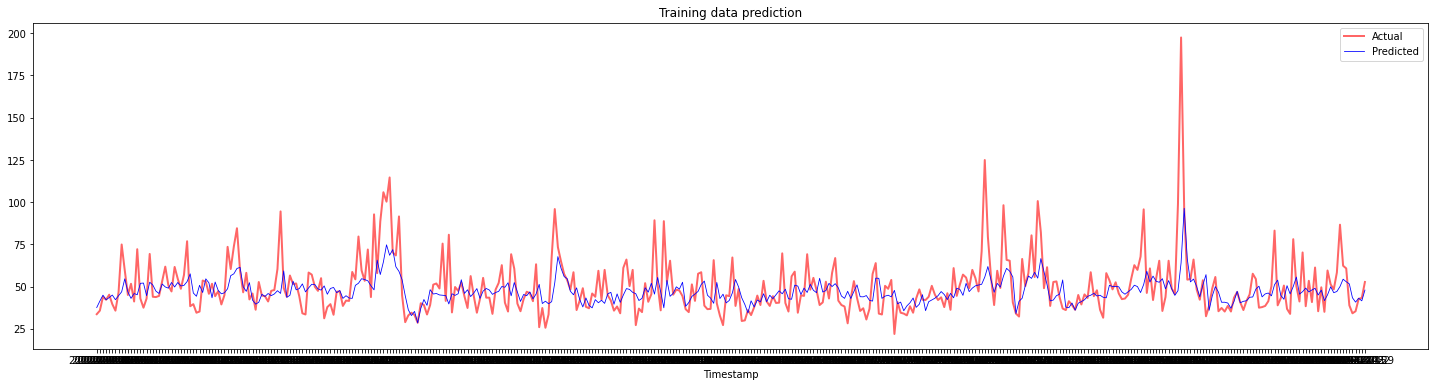

In [24]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [25]:
def calculate_metrics(pred, actual, verbose=True):
    result_metrics = {'mae' : mean_absolute_error(pred, actual),
                      'mape' : mean_absolute_percentage_error(pred, actual),
                      'mse' : mean_squared_error(pred, actual), 
                      'rmse' : mean_squared_error(pred, actual) ** 0.5
                      }
    
    if verbose:
      print("Mean Absolute Error:       ", result_metrics["mae"])
      print("Mean Absolute Percentage Error:       ", result_metrics["mape"])
      print("Mean Squared Error:   ", result_metrics["mse"])
      print("Root Mean Squared Error:   ", result_metrics["rmse"])
      
    return result_metrics

In [26]:
metrics = calculate_metrics(y_train_pred, y_train)

Mean Absolute Error:        9.465506290607298
Mean Absolute Percentage Error:        0.19470099010467995
Mean Squared Error:    224.1456603381398
Root Mean Squared Error:    14.971494926631069


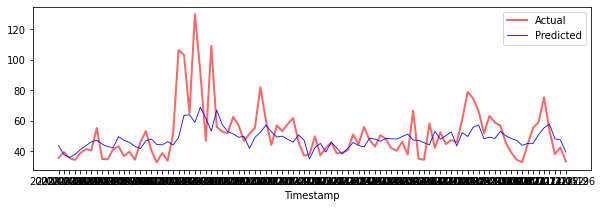

In [27]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [28]:
metrics = calculate_metrics(y_test_pred, y_test)

Mean Absolute Error:        9.787561509116712
Mean Absolute Percentage Error:        0.19560044414277425
Mean Squared Error:    228.36808964353472
Root Mean Squared Error:    15.111852621155842


# Hyperparameter Tune

In [55]:
# Create lagged variables for n timesteps
timesteps = range(1, 11)
n_cols = 5 

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'polynomial']} 

In [57]:
for t in timesteps:
  x_train, y_train = create_sequences(train, t, n_cols)
  x_test, y_test = create_sequences(test, t, n_cols)

  grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 0)
  grid.fit(x_train, y_train[:,0])

  best_kernel = grid.best_params_['kernel']
  best_c = grid.best_params_['C']
  best_gamma = grid.best_params_['gamma']

  model = SVR(kernel= best_kernel, C= best_c, gamma= best_gamma)

  model.fit(x_train, y_train[:,0])

  y_train_pred = model.predict(x_train).reshape(-1,1)
  y_test_pred = model.predict(x_test).reshape(-1,1)

  y_test_pred = inverse_transform(y_test_pred, n_cols) 
  y_test = inverse_transform(y_test, n_cols)

  print("timestep: ", t)
  print("best params:" , best_kernel, best_c, best_gamma)
  metrics = calculate_metrics(y_test_pred, y_test)
  print() 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", lin

timestep:  1
best params: linear 0.1 1
Mean Absolute Error:        9.394918189447097
Mean Absolute Percentage Error:        0.1959741269993363
Mean Squared Error:    232.9053133433717
Root Mean Squared Error:    15.261235642744387



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", lin

timestep:  2
best params: rbf 10 0.001
Mean Absolute Error:        9.177340087924202
Mean Absolute Percentage Error:        0.1892344014838305
Mean Squared Error:    222.8132339937751
Root Mean Squared Error:    14.926929824775593



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", lin

timestep:  3
best params: rbf 10 0.001
Mean Absolute Error:        9.024119174573547
Mean Absolute Percentage Error:        0.1841572184376891
Mean Squared Error:    217.95403979287326
Root Mean Squared Error:    14.763266569186959



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", lin

timestep:  4
best params: rbf 100 0.0001
Mean Absolute Error:        9.003830142411458
Mean Absolute Percentage Error:        0.1821388246180882
Mean Squared Error:    213.38276142616283
Root Mean Squared Error:    14.607626823894524



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", lin

timestep:  5
best params: rbf 100 0.0001
Mean Absolute Error:        9.18336468205953
Mean Absolute Percentage Error:        0.1842246440654458
Mean Squared Error:    213.61713015629147
Root Mean Squared Error:    14.615646758056636



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", lin

timestep:  6
best params: rbf 1 0.01
Mean Absolute Error:        9.773112811922374
Mean Absolute Percentage Error:        0.1997262862316707
Mean Squared Error:    234.77423909426298
Root Mean Squared Error:    15.322344438572806



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", lin

timestep:  7
best params: rbf 1 0.01
Mean Absolute Error:        9.819452260059096
Mean Absolute Percentage Error:        0.19894108569175534
Mean Squared Error:    237.68574376930914
Root Mean Squared Error:    15.417060153262332



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", lin

timestep:  8
best params: rbf 10 0.001
Mean Absolute Error:        9.610719918347765
Mean Absolute Percentage Error:        0.19268748321349985
Mean Squared Error:    225.0781036996667
Root Mean Squared Error:    15.002603230761878

timestep:  9
best params: rbf 10 0.001
Mean Absolute Error:        9.725697779814023
Mean Absolute Percentage Error:        0.19450788174244313
Mean Squared Error:    228.8717291097186
Root Mean Squared Error:    15.12850716725608



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", lin